In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import time

In [23]:
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import numpy as np
import random
import os

def set_seed(seed=42):
    """
    Set random seeds for reproducibility across multiple libraries.
    
    Args
    ----
    seed (int): 
        Seed value to use
    """
    # Set PyTorch seed
    torch.manual_seed(seed)
    
    # Set CUDA seed (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
        
    
    # Set NumPy seed
    np.random.seed(seed)
    
    # Set Python's random seed
    random.seed(seed)
    
    # Set environment variable for some PyTorch operations
    os.environ['PYTHONHASHSEED'] = str(seed)

# Example usage
set_seed(42)  # or any other seed value

In [4]:
class EarlyStopper:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_error = float('inf')
    
    def check(self, val_error, model):
        if val_error < self.min_error - self.min_delta:
            self.min_error = val_error
            torch.save(model.state_dict(), 'best_model.pth')
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [12]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # First convolutional layer
        # Input: 3 channels (RGB), Output: 16 feature maps, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout2d(p=0.1)
        
        # Second convolutional layer
        # Input: 16 feature maps, Output: 32 feature maps, 3x3 kernel
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        # Assuming input images are 32x32, after two 2x2 pooling layers, we have 32/2/2 = 8
        # So the feature maps are 8x8 with 32 channels: 32 * 8 * 8 = 2048
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes (e.g., for CIFAR-10 dataset)
    
    def forward(self, x):
        # Apply convolutional layers
        x = self.drop1(self.pool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        # Flatten the feature maps
        x = x.view(-1, 64 * 4 * 4)
        
        # Apply fully connected layers
        x = self.fc2(self.drop4(self.relu4(self.bn4(self.fc1(x)))))
        
        return x

# 2. Create an instance of the model
model = BasicCNN()
model = model.to(device)

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95, weight_decay=0.0005)
#optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# 4. Load and preprocess data (example with CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.ImageFolder('../../data/processed/train_augmented_rotated/', transform=transform)
valset = torchvision.datasets.ImageFolder('../../data/raw/valid/', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

ES = EarlyStopper(patience=4, min_delta=0)

def train(epochs=5):
    
    time_started = time.time()
    _train_errors = []
    _val_errors = []
    for epoch in range(epochs):
        correct_train = 0
        total = 0
        running_loss = 0.0
        
        epoch_loss = 0.0
        total_batches = 0
        
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            correct_train += (torch.argmax(outputs, 1) == labels).float().sum().item()
            total += len(outputs)
            
            # Print statistics
            running_loss += loss.item()
            
            epoch_loss += loss.item()
            total_batches += 1
            
            if i % 200 == 199:    # Print every 200 mini-batches
                acc = correct_train / len(trainloader)
                print(f'[{epoch + 1}, {i + 1}], time {time.time() - time_started} loss: {running_loss / 200:.3f}, acc: {correct_train/total * 100}%')
                running_loss = 0.0
                
        _train_errors.append(epoch_loss / total_batches)
        val_error = 0
        correct_val = 0
        model.eval()
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_error = val_error + criterion(outputs, labels) * images.size(0)
                correct_val += (torch.argmax(outputs, 1) == labels).float().sum().item()
            val_error = val_error / len(valloader.dataset)
            _val_errors.append(val_error)
            print(f'epoch {epoch + 1} TRAIN error: {epoch_loss / total_batches}, acc: {correct_train/total}')
            print(f'epoch {epoch + 1} VALIDATION error: {val_error}, acc: {correct_val/len(valloader.dataset)}')

        if ES.check(val_error, model):
            print('Early stopping triggered!')
            return _train_errors, _val_errors
    
    return _train_errors, _val_errors

In [13]:
train_errors, val_errors = train(1000)

[1, 200], time 5.581929445266724 loss: 2.061, acc: 24.171875%
[1, 400], time 7.184532403945923 loss: 1.851, acc: 28.0390625%
[1, 600], time 8.797238826751709 loss: 1.766, acc: 30.307291666666668%
[1, 800], time 10.42084002494812 loss: 1.689, acc: 31.863281249999996%
[1, 1000], time 12.000942468643188 loss: 1.654, acc: 33.25%
[1, 1200], time 13.599980115890503 loss: 1.635, acc: 34.20052083333333%
[1, 1400], time 15.205082178115845 loss: 1.637, acc: 34.89732142857142%
[1, 1600], time 16.788684606552124 loss: 1.599, acc: 35.599609375%
[1, 1800], time 18.397432327270508 loss: 1.587, acc: 36.328125%
[1, 2000], time 19.970037937164307 loss: 1.595, acc: 36.828125%
[1, 2200], time 21.5666446685791 loss: 1.558, acc: 37.34659090909091%
[1, 2400], time 23.149752140045166 loss: 1.562, acc: 37.8203125%
[1, 2600], time 24.751858472824097 loss: 1.534, acc: 38.32451923076923%
[1, 2800], time 26.376966953277588 loss: 1.528, acc: 38.699776785714285%
[1, 3000], time 27.974573850631714 loss: 1.538, acc: 3

In [20]:
val_errors = [error.item() for error in val_errors]
train_errors = [error.item() for error in train_errors]

AttributeError: 'float' object has no attribute 'item'

In [21]:
val_errors

[1.3372588157653809,
 1.2188230752944946,
 1.1649056673049927,
 1.1328580379486084,
 1.10721755027771,
 1.0929135084152222,
 1.0857011079788208,
 1.0723203420639038,
 1.0667293071746826,
 1.0526394844055176,
 1.039095163345337,
 1.0307964086532593,
 1.0336157083511353,
 1.0272157192230225,
 1.0201568603515625,
 1.0201719999313354,
 1.0115723609924316,
 1.0105035305023193,
 1.0077552795410156,
 1.0063811540603638,
 1.0138052701950073,
 1.0019172430038452,
 1.0003180503845215,
 1.0071711540222168,
 1.0108094215393066,
 1.0055571794509888,
 0.9953855872154236,
 0.9930347204208374,
 1.0016943216323853,
 0.9979351758956909,
 1.0014150142669678,
 0.9990295171737671]

In [22]:
train_errors

[1.6338206401718987,
 1.415222422027588,
 1.335942827712165,
 1.283900398657057,
 1.2487130006684197,
 1.2187324887805515,
 1.1958250019921197,
 1.1740234076393976,
 1.155056654294332,
 1.1395169295840792,
 1.1264583301756117,
 1.1116882113456725,
 1.104477496094174,
 1.0917700447718302,
 1.084641329966651,
 1.0777994940121969,
 1.066557710366779,
 1.059576832962036,
 1.0532014403661092,
 1.047639622285631,
 1.0390196873876782,
 1.0360867286576165,
 1.027599328162935,
 1.0248288424597847,
 1.0199344754748874,
 1.014524180730184,
 1.0121251190927294,
 1.0085033401330312,
 1.005666101635827,
 0.9994403559896681,
 0.9960463191244338,
 0.9927381872442034]

In [24]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, drop_rate):
        super(DenseLayer, self).__init__()
        # BN-ReLU-Conv(1x1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        
        # BN-ReLU-Conv(3x3)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.drop_rate = drop_rate
        
    def forward(self, x):
        new_features = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.conv2(self.relu2(self.bn2(new_features)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, bn_size, drop_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.add_module('denselayer%d' % (i + 1),
                                  DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size, drop_rate))
            
    def forward(self, x):
        features = x
        for layer in self.layers:
            features = layer(features)
        return features

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 8), 
                 num_init_features=32, bn_size=4, drop_rate=0.2, num_classes=10):
        super(DenseNet, self).__init__()
        
        # First convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            # Add a dense block
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=num_features,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            
            # Add a transition layer between dense blocks (except after the last block)
            if i != len(block_config) - 1:
                trans = Transition(in_channels=num_features, out_channels=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
        
        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        
        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        out = F.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

# Create an instance of the model
model = DenseNet(growth_rate=12, block_config=(6, 12, 8), num_classes=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95, weight_decay=0.0005)
# Alternative: optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Load and preprocess data (using your existing setup)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.ImageFolder('../../data/processed/train_augmented_rotated/', transform=transform)
valset = torchvision.datasets.ImageFolder('../../data/raw/valid/', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

ES = EarlyStopper(patience=4, min_delta=0)

def train(epochs=5):
    time_started = time.time()
    _train_errors = []
    _val_errors = []
    
    for epoch in range(epochs):
        correct_train = 0
        total = 0
        running_loss = 0.0
        
        epoch_loss = 0.0
        total_batches = 0
        
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            correct_train += (torch.argmax(outputs, 1) == labels).float().sum().item()
            total += len(outputs)
            
            # Print statistics
            running_loss += loss.item()
            
            epoch_loss += loss.item()
            total_batches += 1
            
            if i % 200 == 199:    # Print every 200 mini-batches
                acc = correct_train / total
                print(f'[{epoch + 1}, {i + 1}], time {time.time() - time_started:.2f}s loss: {running_loss / 200:.3f}, acc: {acc * 100:.2f}%')
                running_loss = 0.0
                
        _train_errors.append(epoch_loss / total_batches)
        val_error = 0
        correct_val = 0
        
        model.eval()
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_error = val_error + criterion(outputs, labels) * images.size(0)
                correct_val += (torch.argmax(outputs, 1) == labels).float().sum().item()
            val_error = val_error / len(valloader.dataset)
            _val_errors.append(val_error)
            print(f'epoch {epoch + 1} TRAIN error: {epoch_loss / total_batches:.4f}, acc: {correct_train/total:.4f}')
            print(f'epoch {epoch + 1} VALIDATION error: {val_error:.4f}, acc: {correct_val/len(valloader.dataset):.4f}')

        if ES.check(val_error, model):
            print('Early stopping triggered!')
            return _train_errors, _val_errors
    
    return _train_errors, _val_errors

In [25]:
train_errors, val_errors = train(1000)

[1, 200], time 10.94s loss: 2.185, acc: 19.14%
[1, 400], time 17.63s loss: 2.017, acc: 22.30%
[1, 600], time 24.40s loss: 1.924, acc: 24.10%
[1, 800], time 31.57s loss: 1.854, acc: 25.42%
[1, 1000], time 38.44s loss: 1.810, acc: 26.56%
[1, 1200], time 45.36s loss: 1.799, acc: 27.48%
[1, 1400], time 52.29s loss: 1.749, acc: 28.39%
[1, 1600], time 59.04s loss: 1.724, acc: 29.17%
[1, 1800], time 66.07s loss: 1.692, acc: 29.89%
[1, 2000], time 72.99s loss: 1.655, acc: 30.66%
[1, 2200], time 79.88s loss: 1.644, acc: 31.41%
[1, 2400], time 86.66s loss: 1.629, acc: 32.07%
[1, 2600], time 93.54s loss: 1.613, acc: 32.66%
[1, 2800], time 100.52s loss: 1.587, acc: 33.21%
[1, 3000], time 107.11s loss: 1.597, acc: 33.66%
[1, 3200], time 113.57s loss: 1.559, acc: 34.22%
[1, 3400], time 120.33s loss: 1.538, acc: 34.72%
[1, 3600], time 126.91s loss: 1.532, acc: 35.18%
[1, 3800], time 133.47s loss: 1.534, acc: 35.61%
[1, 4000], time 140.11s loss: 1.484, acc: 36.04%
[1, 4200], time 146.75s loss: 1.533, 

In [28]:
val_errors = [error.item() for error in val_errors]
train_errors = [error.item() for error in train_errors]

AttributeError: 'float' object has no attribute 'item'

In [29]:
val_errors

[1.3990191221237183,
 1.2330001592636108,
 1.1466305255889893,
 1.071427345275879,
 1.0172206163406372,
 0.9600944519042969,
 0.9596141576766968,
 0.9200401306152344,
 0.9028377532958984,
 0.9043552279472351,
 0.884101390838623,
 0.8428972959518433,
 0.8844390511512756,
 0.8371550440788269,
 0.8333303928375244,
 0.8150157332420349,
 0.8462653160095215,
 0.8445577621459961,
 0.8477894067764282,
 0.7899123430252075,
 0.7733379602432251,
 0.7804141640663147,
 0.7987033128738403,
 0.7967380285263062,
 0.8039102554321289]

In [30]:
train_errors

[1.6401697391721937,
 1.3514976713498434,
 1.234424605295393,
 1.1527789666811625,
 1.0896000926441616,
 1.0351025211811065,
 0.9925279830349816,
 0.9556316237396664,
 0.923247714334064,
 0.8963217977205912,
 0.8708394589477115,
 0.8495361325475904,
 0.827725604391098,
 0.8104668157524533,
 0.7915131389723884,
 0.7758552071041531,
 0.7629392334037357,
 0.7520453106827206,
 0.7365402299722036,
 0.7245674634271198,
 0.7150805357297262,
 0.7037374505996704,
 0.6959792173438603,
 0.6879621674034331,
 0.6817698967933655]

---

In [11]:
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\micha\AppData\Local\Temp\ipykernel_14556\1559688700.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [104]:
val_error = 0
correct = 0
with torch.no_grad():
    model.eval()
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_error = val_error + criterion(outputs, labels) * images.size(0)
        correct += (torch.argmax(outputs, 1) == labels).float().sum().item()
        val_error = val_error / len(valloader.dataset)
    print(f'epoch NONE val error: {val_error}, acc: {correct/len(valloader.dataset)}')

epoch NONE val error: 0.00020540178229566664, acc: 0.5511888888888888


In [13]:
imgs, labels = next(iter(valloader))

In [16]:
imgs, labels = imgs.to(device), labels.to(device)

In [18]:
output = model(imgs)

---
# Checking

In [132]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

In [128]:
def predict(img):
    #tensor_image = transform(Image.fromarray(img)).unsqueeze(0)
    tensor_image = img_tensor.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(tensor_image)

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Denormalize if your transform normalized the images
    img_np = img_np * 0.5 + 0.5  # Adjust based on your normalization values
    img_np = np.clip(img_np, 0, 1)    
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    
    ax1.imshow(img_np)
    proba = torch.nn.functional.softmax(output, dim=1)[0].tolist()
    sns.barplot(x=trainset.classes, y=proba, ax = ax2)
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45)
    plt.show()
    print(proba)

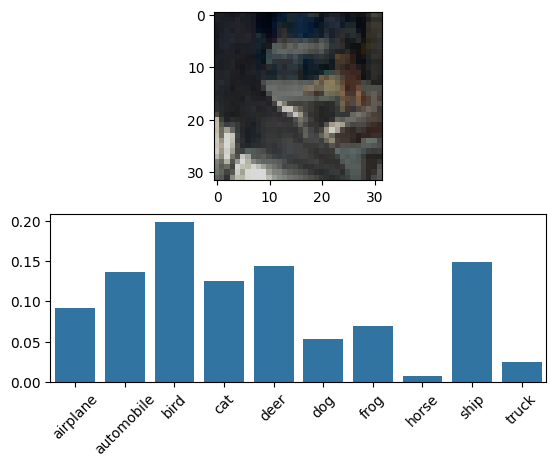

[0.09197390079498291, 0.13637155294418335, 0.1987992525100708, 0.12512052059173584, 0.14453724026679993, 0.05299113318324089, 0.06924711912870407, 0.007855124771595001, 0.14874224364757538, 0.024361854419112206]


In [157]:
img_tensor, label = valloader.dataset[29000]
predict(img_tensor)